# Project: Wrangling and Analyze Data

In [3]:
import pandas as pd
import tweepy
import requests
import json
import numpy as np
import re

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [4]:
tweets = pd.read_csv('twitter-archive-enhanced.csv')
tweets.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [5]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
req = requests.get(url)
url_content = req.content
tsv_file = open('image_predictions.tsv', 'wb')

tsv_file.write(url_content)
tsv_file.close()

In [6]:
image_pred = pd.read_csv('image_predictions.tsv', sep='\t')
image_pred.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [7]:
consumer_key = 'CONSUMER KEY'
consumer_secret = 'CONSUMER SECRET'
access_token = 'ACCESS TOKEN'
access_secret = 'ACCESS SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [8]:
filename = 'tweet_json.txt'

# Convert Series to List for Tweepy
tweet_ids = list(tweets.tweet_id)

# Clear file to avoid duplicates
open(filename, 'w').close()

# Split list of ids into 100x chunks since lookup_statuses method 
# returns full Tweet objects for up to 100 Tweets per request, specified by the id parameter 
# Method lookup_statuses is used instead of get_status since it takes less time to execute (around 20s)
for i in range(0, len(tweet_ids), 100): 
    ids = tweet_ids[i:i + 100]
    fetched_tweets = api.lookup_statuses(ids, include_entities=False, trim_user=True, tweet_mode='extended')
    for tweet in fetched_tweets:
        with open(filename, 'a') as outputfile:
            json.dump(tweet._json, outputfile)
            outputfile.write('\n')

In [9]:
df_list = []
with open('tweet_json.txt') as json_file:
    for line in json_file:
        data = json.loads(line)
        ids = data['id']
        likes = data['favorite_count']
        retweets = data['retweet_count']
        df_list.append({'tweet_id': ids,
                        'likes': int(likes),
                        'retweets': int(retweets)})
engagement = pd.DataFrame(df_list, columns=['tweet_id','likes','retweets'])
engagement.head(3)

,tweet_id,likes,retweets
0,876484053909872640,16864,2038
1,886366144734445568,18897,2688
2,877611172832227328,0,70


In [10]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   tweet_id  2328 non-null   int64
 1   likes     2328 non-null   int64
 2   retweets  2328 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [11]:
# Visual assessment of twitter archive table
tweets.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


#### Columns description:

<br>tweet_id: the unique identifier for each tweet
<br>in_reply_to_status_id: if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID
<br>in_reply_to_user_id: if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s author ID
<br>timestamp: time when this Tweet was created
<br>source: utility used to post the Tweet, as an HTML-formatted string. e.g. Twitter for Android, Twitter for iPhone, Twitter Web Client
<br>text: actual UTF-8 text of the status update
<br>retweeted_status_id: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s ID
<br>retweeted_status_user_id: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s author ID
<br>retweeted_status_timestamp: time of retweet
<br>expanded_urls: tweet URL
<br>rating_numerator: numerator of the rating of a dog. Note: ratings almost always greater than 10
<br>rating_denominator: denominator of the rating of a dog. Note: ratings almost always have a denominator of 10
<br>name: name of the dog
<br>doggo: one of the 4 dog "stage"
<br>floofer: one of the 4 dog "stage"
<br>pupper: one of the 4 dog "stage"
<br>puppo: one of the 4 dog "stage"

In [12]:
tweets.sample(7)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1194,717428917016076293,NaN,NaN,2016-04-05 19:09:17 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Skittle. He's trying to communicate. 1...,NaN,NaN,NaN,https://vine.co/v/iIhEU2lVqxz,11,10,Skittle,None,None,None,None
1146,727155742655025152,NaN,NaN,2016-05-02 15:20:13 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",When you're trying to enjoy yourself but end u...,NaN,NaN,NaN,https://vine.co/v/ixa1ejbXiM7,11,10,None,None,None,None,None
1195,717421804990701568,NaN,NaN,2016-04-05 18:41:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ebby. She's a Zimbabwean Feta. Embarra...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717421804...,9,10,Ebby,None,None,None,None
1959,673576835670777856,NaN,NaN,2015-12-06 18:56:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Sun burnt dog here. Quite large. Wants to prom...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673576835...,7,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,13615722.0,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
2178,669015743032369152,NaN,NaN,2015-11-24 04:52:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Super rare dog right here guys. Doesn't bark. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669015743...,10,10,None,None,None,None,None
989,748932637671223296,NaN,NaN,2016-07-01 17:33:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Divine Doggo. Must be magical af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748932637...,13,10,Divine,doggo,None,None,None


In [13]:
# Programmatic assessment of twitter archive table
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [14]:
tweets.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
0         1
120       1
7         1
170       1
150       1
130       1
90        1
110       1
2         1
70        1
40        1
16        1
15        1
Name: rating_denominator, dtype: int64

In [15]:
tweets.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
0         2
15        2
75        2
420       2
182       1
204       1
143       1
121       1
99        1
20        1
45        1
27        1
17        1
24        1
26        1
44        1
50        1
60        1
80        1
84        1
88        1
1776      1
960       1
666       1
144       1
165       1
Name: rating_numerator, dtype: int64

In [16]:
sum(tweets['tweet_id'].duplicated())

0

In [17]:
tweets.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [18]:
tweets.name.value_counts().sort_index(ascending=False)

very            5
unacceptable    1
this            1
the             8
such            1
               ..
Aiden           1
Adele           1
Acro            1
Ace             1
Abby            2
Name: name, Length: 957, dtype: int64

In [19]:
tweets[tweets['name'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [20]:
# Visual assessment of image prediction table
image_pred.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


Image prediction columns description:

<br>tweet_id: the unique identifier for each tweet
<br>jpg_url: dog's image URL
<br>img_num: the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images)
<br>p1: algorithm's #1 prediction for the image in the tweet
<br>p1_conf: how confident the algorithm is in its #1 prediction
<br>p1_dog: whether or not the #1 prediction is a breed of dog
<br>p2: algorithm's #2 prediction for the image in the tweet
<br>p2_conf: how confident the algorithm is in its #2 prediction
<br>p2_dog: whether or not the #2 prediction is a breed of dog
<br>p3: algorithm's #3 prediction for the image in the tweet
<br>p3_conf: how confident the algorithm is in its #3 prediction
<br>p3_dog: whether or not the #3 prediction is a breed of dog

In [21]:
image_pred.sample(7)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1774,828046555563323392,https://pbs.twimg.com/media/C33P8PrUcAMiQQs.jpg,3,patio,0.272972,False,window_screen,0.131295,False,boathouse,0.046393,False
1544,791672322847637504,https://pbs.twimg.com/media/CvyVxQRWEAAdSZS.jpg,1,golden_retriever,0.705092,True,Labrador_retriever,0.219721,True,kuvasz,0.015965,True
57,667073648344346624,https://pbs.twimg.com/media/CUHr8WbWEAEBPgf.jpg,1,Chihuahua,0.483682,True,pug,0.092494,True,Brabancon_griffon,0.057495,True
1284,750506206503038976,https://pbs.twimg.com/media/CmpVaOZWIAAp3z6.jpg,1,American_black_bear,0.219166,False,lesser_panda,0.214715,False,titi,0.091685,False
233,670420569653809152,https://pbs.twimg.com/media/CU3P82RWEAAIVrE.jpg,1,bow_tie,0.268759,False,cardigan,0.153957,False,wig,0.072295,False
16,666102155909144576,https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg,1,English_setter,0.298617,True,Newfoundland,0.149842,True,borzoi,0.133649,True
271,670823764196741120,https://pbs.twimg.com/media/CU8-puBWwAAR8Xl.jpg,1,Labrador_retriever,0.947453,True,German_short-haired_pointer,0.017001,True,Weimaraner,0.015432,True


In [22]:
# Programmatic assessment of image prediction table
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
sum(image_pred.tweet_id.duplicated())

0

In [24]:
print(image_pred.p1_dog.value_counts())

True     1532
False     543
Name: p1_dog, dtype: int64


In [25]:
# Visual assessment of engagement table
engagement.head(3)

,tweet_id,likes,retweets
0,876484053909872640,16864,2038
1,886366144734445568,18897,2688
2,877611172832227328,0,70


In [26]:
# Proggramatic assessment of engagement table
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   tweet_id  2328 non-null   int64
 1   likes     2328 non-null   int64
 2   retweets  2328 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


### Quality issues

• [#1](#issue_1) Number of observations differ in twitter-archive-enhanced(2356), imgage_predictions(2075) and tweet_json(2327).

• [#4](#issue_4) Set up tweet_id column as index in tweets_master table for work confinience.

• [#5](#issue_5) Some rows contain more than one dog stage.

• [#6](#issue_6) Missing values in doggo, floofer, pupper and puppo columns.

• [#8](#issue_8) Redundant retweet rows.

• [#9](#issue_9) Redundant columns 'in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls' in tweets table. 

• [#10](#issue_10) Wrong data type of ‘timestamp’ (object instead of timestamp) column.

• [#11](#issue_11) Inconsistencies in the 'rating_denominator' column need to be investigated and fixed if possible. Issues might have happened during text parsing and though I'll display text to check it.

• [#12](#issue_12)There are inconsistencies in the 'rating_numerator' column (numerator is greater than denominator, too great values). 'Numerator is greater than denominator' is mainly a feature of WeRateDogs account, but partly might be an issue during text parsing.

• [#13](#issue_13) Upper and lowercase breed names.

### Tidiness issues

• [#2](#issue_2) Breeds and confidence levels for the breed predictions column from the image prediction table should be part of the tweets table.

• [#3](#issue_3) Engagement table (retweet_count and favorite_count columns) should be part of the tweets table.

• [#7](#issue_7) 4 columns (doggo, floofer, pupper, puppo) are categories of dog ‘stage’ and need to be one column ‘stage’ with 4 categories: doggo, floofer, pupper and puppo in it.

## Cleaning Data

In [27]:
# Make copies of original pieces of data
tweets_clean = tweets.copy()
image_pred_clean = image_pred.copy()
engagement_clean = engagement.copy()

<a id='issue_1'></a>
### Issue #1:

Number of observations differ in twitter-archive-enhanced(2356), imgage_predictions(2075) and tweet_json(2327).
<br>
<br> Even thou this is an important issue to fix it can't be addressed in this project due to project's set up (we don't have ids of the rest of the tweets in twitter archive to be able to downlode them, some tweets have been deleted and their data are unaccesseble). 

### Tidiness issues

To be able to analyse WeRateDogs tweets I need to create one DataFrame containing necessary information: about tweets themself (tweets table), dogs breed column based on predictions in image prediction table and amount of likes and retweets from engagement table. 

<a id='issue_2'></a>
### Issue #2:
#### Define
Breed prediction and it's confidence level from image prediction table need to be part of the main (tweets) table. To do so I am going to isolate breed prediction for each row based on True/False in p1_dog, p2_dog, p3_dog columns, take corresponding confidence level and merge them with tweets table as 'breed' and 'confidence_level' columns based on 'tweet_id' column.

#### Code

In [28]:
# Empty lists to transform them into DF later
tweet_id = []
breed = []
confidence_level = []

# Function that checks breed predictions and add tweet_id, breed and confidence_level to corresponding lists
def predictions(image_pred_clean):
    if image_pred_clean['p1_dog'] == True:
        breed.append(image_pred_clean['p1'])
        confidence_level.append(image_pred_clean['p1_conf'])
        tweet_id.append(image_pred_clean['tweet_id'])
    elif image_pred_clean['p2_dog'] == True:
        breed.append(image_pred_clean['p2'])
        confidence_level.append(image_pred_clean['p2_conf'])
        tweet_id.append(image_pred_clean['tweet_id'])
    elif image_pred_clean['p3_dog'] == True:
        breed.append(image_pred_clean['p3'])
        confidence_level.append(image_pred_clean['p3_conf'])
        tweet_id.append(image_pred_clean['tweet_id'])
    else:
        tweet_id.append(image_pred_clean['tweet_id'])
        breed.append(np.nan)
        confidence_level.append(np.nan)
        
# Apply above function on image prediction table
image_pred_clean.apply(predictions, axis=1)

# Transform lists into data frame
breeds = pd.DataFrame({'tweet_id': tweet_id, 'breed': breed, 'confidence_level': confidence_level})

In [29]:
# Merge tweets and breeds tables
tweets_master = pd.merge(tweets_clean, breeds, on=['tweet_id'], how='left')

#### Test

In [30]:
tweets_master.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,breed,confidence_level
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,Chihuahua,0.323581


<a id='issue_3'></a>
### Issue #3:
#### Define
Engagment table need to be part of the main (tweets) table. I am going to merge them using 'tweet_id' column as base.

#### Code

In [31]:
# Merge tweets and breeds tables
tweets_master = pd.merge(tweets_master, engagement_clean, on=['tweet_id'], how='left')

# Preserve 'likes' and 'retweets' columns data types
tweets_master['likes']=tweets_master['likes'].astype('Int64')
tweets_master['retweets']=tweets_master['retweets'].astype('Int64')

#### Test

In [32]:
tweets_master.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,breed,confidence_level,likes,retweets
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,10,Phineas,None,None,None,None,NaN,NaN,34422,7153
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,10,Tilly,None,None,None,None,Chihuahua,0.323581,29850,5380


In [33]:
tweets_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

<a id='issue_4'></a>
### Issue #4:
#### Define
Set up tweet_id column as index in tweets_master table for work confinience.

#### Code

In [34]:
tweets_master['tweet_id'] = tweets_master['tweet_id'].astype(str)
tweets_master = tweets_master.set_index('tweet_id')

#### Test

In [35]:
tweets_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   in_reply_to_status_id       78 non-null     float64
 1   in_reply_to_user_id         78 non-null     float64
 2   timestamp                   2356 non-null   object 
 3   source                      2356 non-null   object 
 4   text                        2356 non-null   object 
 5   retweeted_status_id         181 non-null    float64
 6   retweeted_status_user_id    181 non-null    float64
 7   retweeted_status_timestamp  181 non-null    object 
 8   expanded_urls               2297 non-null   object 
 9   rating_numerator            2356 non-null   int64  
 10  rating_denominator          2356 non-null   int64  
 11  name                        2356 non-null   object 
 12  doggo                       2356 non-null   object 
 13  floofer

#### NB
To be able to fix the last one tideness issue (transform doggo, floofer, pupper and puppo columns into one with 4 categories) I need to clean up few quality issues related to these columns.

<a id='issue_5'></a>
### Issue #5:
#### Define
Some rows contain more than one dog stage. Since there are not so many such rows it is possible to fix them manually by reading tweets' text.

#### Code

In [36]:
for index, tweet in tweets_master.iterrows():
    count = 0
    if tweet.doggo != 'None':
        count += 1
    if tweet.floofer != 'None':
        count += 1
    if tweet.pupper != 'None':
        count += 1
    if tweet.puppo != 'None':
        count += 1
    if count > 1:
        with pd.option_context('max_colwidth', 150):
            print(index, tweet.text, [tweet.doggo, tweet.floofer, tweet.pupper, tweet.puppo])

doggo_to_none = ['855851453814013952', '854010172552949760', '817777686764523521', '808106460588765185',
                 '801115127852503040', '781308096455073793', '751583847268179968', '741067306818797568']

for tweet in doggo_to_none:
    tweets_master.at[tweet, 'doggo'] = 'None'
    
pupper_to_none = ['802265048156610565', '785639753186217984', '759793422261743616', '751583847268179968', '733109485275860992'] 

for tweet in pupper_to_none:
    tweets_master.at[tweet, 'pupper'] = 'None'

#### Test

for index, tweet in tweets_master.iterrows():
    count = 0
    if tweet.doggo != 'None':
        count += 1
    if tweet.floofer != 'None':
        count += 1
    if tweet.pupper != 'None':
        count += 1
    if tweet.puppo != 'None':
        count += 1
    if count > 1:
        with pd.option_context('max_colwidth', 150):
            print(index, tweet.text, [tweet.doggo, tweet.floofer, tweet.pupper, tweet.puppo])

855851453814013952 Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel ['doggo', 'None', 'None', 'puppo']
854010172552949760 At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk ['doggo', 'floofer', 'None', 'None']
817777686764523521 This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7 ['doggo', 'None', 'pupper', 'None']
808106460588765185 Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho ['doggo', 'None', 'pupper', 'None']
802265048156610565 Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze ['doggo', 'None', 'pupper', 'None']
801115127852503040 Th

In [37]:
doggo_to_none = ['855851453814013952', '854010172552949760', '817777686764523521', '808106460588765185',
                 '801115127852503040', '781308096455073793', '751583847268179968', '741067306818797568', '770093767776997377']

for tweet in doggo_to_none:
    tweets_master.at[tweet, 'doggo'] = 'None'
    
pupper_to_none = ['802265048156610565', '785639753186217984', '759793422261743616', '751583847268179968',
                  '733109485275860992', '775898661951791106'] 

for tweet in pupper_to_none:
    tweets_master.at[tweet, 'pupper'] = 'None'

#### Test

In [38]:
for index, tweet in tweets_master.iterrows():
    count = 0
    if tweet.doggo != 'None':
        count += 1
    if tweet.floofer != 'None':
        count += 1
    if tweet.pupper != 'None':
        count += 1
    if tweet.puppo != 'None':
        count += 1
    if count > 1:
        with pd.option_context('max_colwidth', 150):
            print(index, tweet.text, [tweet.doggo, tweet.floofer, tweet.pupper, tweet.puppo])

<a id='issue_6'></a>
### Issue #6:
#### Define
Missing values in doggo, floofer, pupper and puppo columns are strings 'None' instead of NaN.

#### Code

In [39]:
dog_stages = ['doggo', 'floofer', 'pupper', 'puppo']
for stage in dog_stages:
    tweets_master[stage].replace('None', np.nan, inplace=True)

#### Test

In [40]:
tweets_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   in_reply_to_status_id       78 non-null     float64
 1   in_reply_to_user_id         78 non-null     float64
 2   timestamp                   2356 non-null   object 
 3   source                      2356 non-null   object 
 4   text                        2356 non-null   object 
 5   retweeted_status_id         181 non-null    float64
 6   retweeted_status_user_id    181 non-null    float64
 7   retweeted_status_timestamp  181 non-null    object 
 8   expanded_urls               2297 non-null   object 
 9   rating_numerator            2356 non-null   int64  
 10  rating_denominator          2356 non-null   int64  
 11  name                        2356 non-null   object 
 12  doggo                       88 non-null     object 
 13  floofer

<a id='issue_7'></a>
### Issue #7:
#### Define
4 columns (doggo, floofer, pupper, puppo) are categories of dog ‘stage’ and need to be one column ‘stage’ with 4 categories: doggo, floofer, pupper and puppo in it.

#### Code

In [41]:
# Melt the doggo, floofer, pupper and puppo columns to dogs and dogs_stage column
tweets_master = pd.melt(tweets_master, id_vars=['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source',
                                                'text', 'retweeted_status_id', 'retweeted_status_user_id',
                                                'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 
                                                'rating_denominator', 'name', 'breed', 'confidence_level', 'likes', 'retweets'], 
                      var_name='dog', value_name='dog_stage', ignore_index=False)

tweets_master = tweets_master.sort_values(by=['dog_stage'])
tweets_master = tweets_master[~tweets_master.index.duplicated(keep='first')].drop('dog', 1)

#### Test

In [42]:
tweets_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2356 entries, 890240255349198849 to 666020888022790149
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   in_reply_to_status_id       78 non-null     float64
 1   in_reply_to_user_id         78 non-null     float64
 2   timestamp                   2356 non-null   object 
 3   source                      2356 non-null   object 
 4   text                        2356 non-null   object 
 5   retweeted_status_id         181 non-null    float64
 6   retweeted_status_user_id    181 non-null    float64
 7   retweeted_status_timestamp  181 non-null    object 
 8   expanded_urls               2297 non-null   object 
 9   rating_numerator            2356 non-null   int64  
 10  rating_denominator          2356 non-null   int64  
 11  name                        2356 non-null   object 
 12  breed                       1751 non-null   object 
 13  confide

<a id='issue_8'></a>
### Issue #8:
#### Define
Drop rows containing information about retweets using 'retweeted_status_id' column by saving only rows where is Nan in this column.

#### Code

In [43]:
tweets_master = tweets_master[tweets_master.retweeted_status_user_id.isnull()]

#### Test

In [44]:
len(tweets_master[tweets_master.retweeted_status_user_id.isnull() == False])

0

<a id='issue_9'></a>
### Issue #9:
#### Define
Redundand columns 'in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls' in tweets table.

#### Code

In [45]:
tweets_master = tweets_master.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id',
                                    'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'], 1)

#### Test

In [46]:
tweets_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2175 entries, 890240255349198849 to 666020888022790149
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           2175 non-null   object 
 1   text                2175 non-null   object 
 2   rating_numerator    2175 non-null   int64  
 3   rating_denominator  2175 non-null   int64  
 4   name                2175 non-null   object 
 5   breed               1686 non-null   object 
 6   confidence_level    1686 non-null   float64
 7   likes               2167 non-null   Int64  
 8   retweets            2167 non-null   Int64  
 9   dog_stage           343 non-null    object 
dtypes: Int64(2), float64(1), int64(2), object(5)
memory usage: 191.2+ KB


<a id='issue_10'></a>
### Issue #10:
#### Define
Wrong data type of ‘timestamp’ (object instead of timestamp) column.

#### Code

In [47]:
tweets_master['timestamp'] = pd.to_datetime(tweets_master['timestamp'])

#### Test

In [48]:
tweets_master.dtypes

timestamp             datetime64[ns, UTC]
text                               object
rating_numerator                    int64
rating_denominator                  int64
name                               object
breed                              object
confidence_level                  float64
likes                               Int64
retweets                            Int64
dog_stage                          object
dtype: object

<a id='issue_11'></a>
### Issue #11:
#### Define
Inconsistencies in 'rating_denominator' column need to be investigated and fixed if possible. Issues might have happened during text parsing and thou I'll display text to check it.

#### Code

In [49]:
# display text for all tweet where denominator is not 10
for index, tweet in tweets_master.iterrows():
    if tweet.rating_denominator != 10:
        with pd.option_context('max_colwidth', 150):
            print(index, tweet.text, tweet.rating_denominator)

835246439529840640 @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho 0
832088576586297345 @docmisterio account started on 11/15/15 15
820690176645140481 The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd 70
810984652412424192 Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx 7
758467244762497024 Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE 150
740373189193256964 After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ 11
731156023742988288 Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv 170
722974582966214656 Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a 20
716439118

In [50]:
# list of tweet ids to drop
to_drop = ['835246439529840640', '832088576586297345', '686035780142297088', '684225744407494656']
tweets_master = tweets_master.drop(to_drop)

# list of tweet ids to change denominator to 10
to_10 = ['820690176645140481', '758467244762497024', '740373189193256964', '731156023742988288', '722974582966214656', 
         '716439118184652801', '713900603437621249', '710658690886586372', '709198395643068416', '704054845121142784',
         '697463031882764288', '684222868335505415', '682962037429899265', '677716515794329600', '675853064436391936', '666287406224695296']
for tweet in to_10:
    tweets_master.at[tweet, 'rating_denominator'] = int(10)

# list tweet ids to change to NaN
tweets_master.at['810984652412424192', 'rating_denominator'] = None
tweets_master.at['682808988178739200', 'rating_denominator'] = None

#### Test

In [51]:
tweets_master.rating_denominator.value_counts()

10.0    2169
Name: rating_denominator, dtype: int64

<a id='issue_12'></a>
### Issue #12:
#### Define
There are inconsistencies in 'rating_numerator' column (numerator is greater than denominator, too great values). 'Numerator is greater than denominator' is mainly feature of WeRateDogs account, but partly might be an issues durind text parsing.

In [52]:
# correct numerators in tweets investigated in issue #11

nto_9 = ['709198395643068416', '666287406224695296']
for tweet in nto_9:
    tweets_master.at[tweet, 'rating_numerator'] = 9
    
nto_10 = ['710658690886586372', '682962037429899265']
for tweet in nto_10:
    tweets_master.at[tweet, 'rating_numerator'] = 10
    
nto_11 = ['758467244762497024', '716439118184652801', '713900603437621249', '697463031882764288', '684222868335505415', '675853064436391936']
for tweet in nto_11:
    tweets_master.at[tweet, 'rating_numerator'] = 11
    
nto_12 = ['820690176645140481', '731156023742988288', '704054845121142784', '677716515794329600']
for tweet in nto_12:
    tweets_master.at[tweet, 'rating_numerator'] = 12
    
tweets_master.at['722974582966214656', 'rating_numerator'] = 13
tweets_master.at['740373189193256964', 'rating_numerator'] = 14

nto_nan = ['810984652412424192', '682808988178739200']
for tweet in nto_nan:
    tweets_master.at[tweet, 'rating_numerator'] = None

In [53]:
tweets_master.rating_numerator.value_counts()

12.0      504
10.0      444
11.0      431
13.0      308
9.0       157
8.0        98
7.0        53
14.0       44
5.0        36
6.0        32
3.0        19
4.0        15
2.0         9
1.0         7
420.0       2
0.0         2
15.0        1
1776.0      1
17.0        1
26.0        1
27.0        1
182.0       1
75.0        1
666.0       1
Name: rating_numerator, dtype: int64

In [54]:
# display tweets with 5 in numerator column
tweets_master.loc[tweets_master.rating_numerator == 5].text

tweet_id
684880619965411328    Here we have a basking dino pupper. Looks powe...
883482846933004288    This is Bella. She hopes her smile made you sm...
781661882474196992    Who keeps sending in pictures without dogs in ...
751583847268179968    Please stop sending it pictures that don't eve...
699691744225525762    This is Dave. He's a tropical pup. Short lil l...
694925794720792577    Please only send in dogs. This t-rex is very s...
691483041324204033    When bae says they can't go out but you see th...
687102708889812993    Army of water dogs here. None of them know whe...
684969860808454144    For those who claim this is a goat, u are wron...
684959798585110529    This is Jerry. He's a neat dog. No legs (tragi...
683849932751646720    This is Jiminy. He's not the brightest dog. Ne...
682003177596559360    Unique dog here. Wrinkly as hell. Weird segmen...
681340665377193984    I've been told there's a slight possibility he...
679877062409191424    Meet Penelope. She's a bacon fris

In [55]:
# check one of them
tweets_master.loc['883482846933004288'].text

'This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948'

In [56]:
# part of the issue are unexpected floats so I need to find and fix them manualy

with pd.option_context('max_colwidth', 150):
    display(tweets_master[tweets_master.text.str.contains(r"(\d+\.\d*\/\d+)").fillna(False)]
            [['text', 'rating_numerator']])

/Users/izumita/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,text,rating_numerator
tweet_id,,
778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://...,27.0
883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5.0
786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75.0
681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5.0
680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26.0


In [57]:
# change data type in rating_numerator column from integer to float to be able to add correct values
tweets_master['rating_numerator'] = tweets_master['rating_numerator'].astype(float)

# correct values for 5 tweets displayed above
tweets_master.at['883482846933004288', 'rating_numerator'] = 13.5
tweets_master.at['786709082849828864', 'rating_numerator'] = 9.75
tweets_master.at['778027034220126208', 'rating_numerator'] = 11.27
tweets_master.at['681340665377193984', 'rating_numerator'] = 9.5
tweets_master.at['680494726643068929', 'rating_numerator'] = 11.26

In [58]:
# check out the text of some outlyers in rating_numerator column
numerators = [0, 1, 2, 15, 17, 20, 24, 182, 420, 666, 1776]

for index, tweet in tweets_master.iterrows():
    if tweet.rating_numerator in numerators:
        with pd.option_context('max_colwidth', 150):
            print(index, tweet.text, tweet.rating_numerator)

881633300179243008 @roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s 17.0
855862651834028034 @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research 420.0
855860136149123072 @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10 666.0
838150277551247360 @markhoppus 182/10 182.0
838085839343206401 @bragg6of8 @Andy_Pace_ we are still looking for the first 15/10 15.0
835152434251116546 When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag 0.0
749981277374128128 This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh 1776.0
746906459439529985 PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX 0.0
696490539101908992 After reading the comments I may have overestimated this pup. Downgraded to a

In [59]:
# After deep look into tweets above there have been found out that some tweets contain no dogs, 
# other are replies with corrections and some ratings are ment by the author. 

# Therefor 'not a dog' tweets and replyes to tweets that are not presented in our dataset will be droped 
# '696490539101908992' is downgrade for '696488710901260288', will change numerator to 1 and then drop '696490539101908992'

#the author ment it, will keep: '855860136149123072', '749981277374128128', '678424312106393600', '675153376133427200'

tweets_master.at['696488710901260288', 'rating_numerator'] = 1

tweets_master.at['810984652412424192', 'rating_numerator'] = None

rows_to_drop = ['671550332464455680', '838150277551247360', '696490539101908992', '673716320723169284', 
                '855862651834028034', '670842764863651840', '835152434251116546', '678675843183484930', 
                '674265582246694913', '670826280409919488', '670783437142401025', '668142349051129856',
                '667549055577362432', '666786068205871104', '666411507551481857','666104133288665088', 
                '746906459439529985', '666051853826850816','881633300179243008', '838085839343206401', 
                '682808988178739200', '682788441537560576', '667878741721415682']
tweets_master = tweets_master.drop(rows_to_drop)

#### Test

In [60]:
tweets_master.rating_numerator.value_counts().sort_index()

1.00         2
2.00         1
3.00        19
4.00        15
5.00        34
6.00        32
7.00        53
8.00        98
9.00       157
9.50         1
9.75         1
10.00      444
11.00      431
11.26        1
11.27        1
12.00      502
13.00      308
13.50        1
14.00       44
666.00       1
1776.00      1
Name: rating_numerator, dtype: int64

<a id='issue_13'></a>
### Issue #13:
#### Define
Upper and lower case breed names.

#### Code

In [61]:
tweets_master.breed.value_counts().sort_index()

Afghan_hound                       3
Airedale                          12
American_Staffordshire_terrier    15
Appenzeller                        2
Australian_terrier                 2
                                  ..
toy_poodle                        51
toy_terrier                        3
vizsla                            13
whippet                           11
wire-haired_fox_terrier            2
Name: breed, Length: 113, dtype: int64

In [62]:
tweets_master['breed'] = tweets_master['breed'].str.lower()

#### Test

In [63]:
tweets_master.breed.value_counts().sort_index()

afghan_hound                       3
airedale                          12
american_staffordshire_terrier    15
appenzeller                        2
australian_terrier                 2
                                  ..
welsh_springer_spaniel             4
west_highland_white_terrier       16
whippet                           11
wire-haired_fox_terrier            2
yorkshire_terrier                 10
Name: breed, Length: 113, dtype: int64

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [64]:
# Save cleaned data (tweets_master table) in a CSV file
tweets_master.to_csv('twitter_archive_master.csv')

In [65]:
tweets_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2148 entries, 890240255349198849 to 666020888022790149
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   timestamp           2148 non-null   datetime64[ns, UTC]
 1   text                2148 non-null   object             
 2   rating_numerator    2147 non-null   float64            
 3   rating_denominator  2147 non-null   float64            
 4   name                2148 non-null   object             
 5   breed               1683 non-null   object             
 6   confidence_level    1683 non-null   float64            
 7   likes               2140 non-null   Int64              
 8   retweets            2140 non-null   Int64              
 9   dog_stage           342 non-null    object             
dtypes: Int64(2), datetime64[ns, UTC](1), float64(3), object(4)
memory usage: 188.8+ KB


## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [66]:
tweets_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2148 entries, 890240255349198849 to 666020888022790149
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   timestamp           2148 non-null   datetime64[ns, UTC]
 1   text                2148 non-null   object             
 2   rating_numerator    2147 non-null   float64            
 3   rating_denominator  2147 non-null   float64            
 4   name                2148 non-null   object             
 5   breed               1683 non-null   object             
 6   confidence_level    1683 non-null   float64            
 7   likes               2140 non-null   Int64              
 8   retweets            2140 non-null   Int64              
 9   dog_stage           342 non-null    object             
dtypes: Int64(2), datetime64[ns, UTC](1), float64(3), object(4)
memory usage: 188.8+ KB


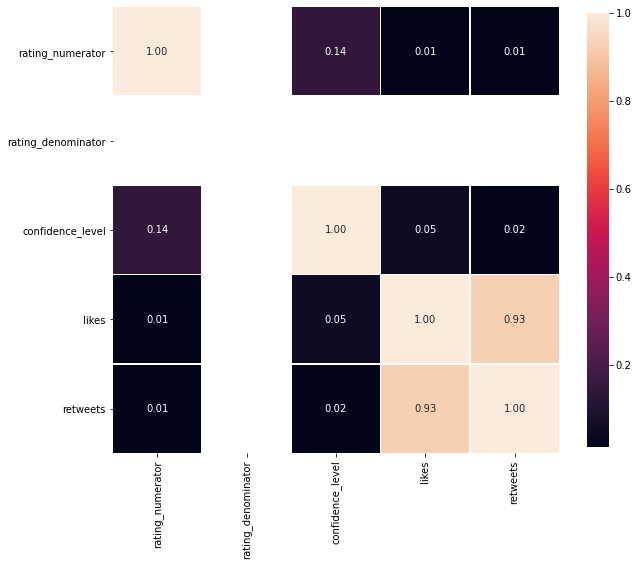

In [67]:
# create heatmap of correlations in the data frame

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
def correlation_heatmap(df):
    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, fmt='.2f', square=True, linewidths=.3, 
                annot=True, cbar_kws={"shrink": .80})
    plt.show();
    
correlation_heatmap(tweets_master)

#### retweets, likes and ratings by dogs stage

In [68]:
print('Mean retweets amount: ', round(tweets_master.retweets.mean()))
print('Mean likes amount: ', round(tweets_master.likes.mean()))

Mean retweets amount:  2300
Mean likes amount:  7772


In [69]:
dog_stages = tweets_master[tweets_master['dog_stage'].isnull()==False]
dogs_likes = dog_stages.groupby('dog_stage').likes.mean()
dogs_likes

dog_stage
doggo      16078.538462
floofer         10131.4
pupper       6358.54386
puppo          20078.32
Name: likes, dtype: Float64

In [70]:
dogs_retweets = dog_stages.groupby('dog_stage').retweets.mean()
dogs_retweets

dog_stage
doggo      5405.307692
floofer         3347.7
pupper     2041.776316
puppo          5755.48
Name: retweets, dtype: Float64

In [71]:
dogs_ratings = dog_stages.groupby('dog_stage').rating_numerator.mean()
dogs_ratings

dog_stage
doggo      11.822785
floofer    11.800000
pupper     10.764342
puppo      12.080000
Name: rating_numerator, dtype: float64

#### breeds

In [72]:
breeds_rating = tweets_master.groupby('breed').rating_numerator.mean().sort_values(ascending=False)
breeds_rating[:10]

breed
bouvier_des_flandres    13.000000
saluki                  12.500000
tibetan_mastiff         12.250000
border_terrier          12.142857
silky_terrier           12.000000
standard_schnauzer      12.000000
irish_setter            11.750000
gordon_setter           11.750000
samoyed                 11.690476
golden_retriever        11.618590
Name: rating_numerator, dtype: float64

In [73]:
breeds_retweets = tweets_master.groupby('breed').retweets.mean().sort_values(ascending=False)
breeds_retweets[:10].index

Index(['bedlington_terrier', 'afghan_hound', 'standard_poodle',
       'french_bulldog', 'english_springer', 'saluki', 'whippet',
       'cocker_spaniel', 'eskimo_dog', 'samoyed'],
      dtype='object', name='breed')

In [74]:
breeds_likes = tweets_master.groupby('breed').likes.mean().sort_values(ascending=False)
breeds_likes[:10]

breed
bedlington_terrier         21965.166667
saluki                         21189.75
french_bulldog             17862.066667
bouvier_des_flandres            15659.0
afghan_hound                    14989.0
black-and-tan_coonhound         14927.0
flat-coated_retriever          14794.75
irish_water_spaniel        14235.666667
leonberg                   12890.333333
whippet                    12824.272727
Name: likes, dtype: Float64

#### Does rating affect likes/retweets?

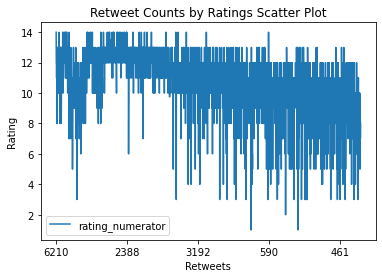

In [75]:
without_outlyers_rating = tweets_master.query('rating_numerator < 20')
without_outlyers_rating
without_outlyers_rating.plot(x='retweets', y='rating_numerator')
plt.xlabel('Retweets')
plt.ylabel('Rating')
plt.title('Retweet Counts by Ratings Scatter Plot');

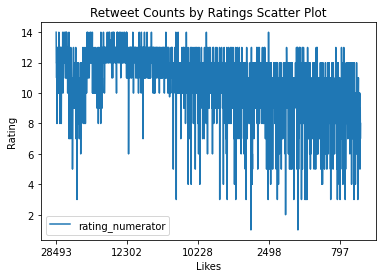

In [76]:
without_outlyers_rating = tweets_master.query('rating_numerator < 20')
without_outlyers_rating
without_outlyers_rating.plot(x='likes', y='rating_numerator')
plt.xlabel('Likes')
plt.ylabel('Rating')
plt.title('Retweet Counts by Ratings Scatter Plot');

<AxesSubplot:xlabel='retweets', ylabel='likes'>

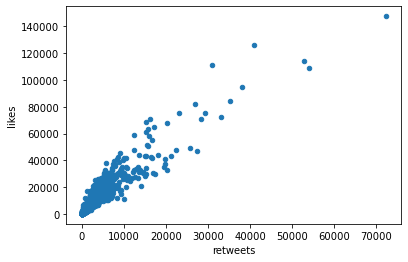

In [77]:
tweets_master.plot.scatter(x='retweets', y='likes')

### Insights:
1. According to heatmap and scatter plots there is no correlation between rating of a dog and amount of likes and retweets it gets.

2. Puppo and pupper are most favorable stages of dog, they have the highest ratings and the most of likes/retweets. 

3. The most popular breeds judging by rating/likes/retweets: saluki, bouvier_des_flandres, samoyed, bedlington_terrier, french_bulldog, afghan_hound,whippet

### Visualization

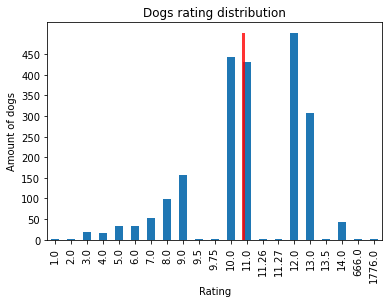

In [78]:
# rating distribution

rating_distribution = tweets_master.rating_numerator.value_counts().sort_index().plot.bar()
plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])
plt.xlabel('Rating')
plt.ylabel('Amount of dogs')
plt.title('Dogs rating distribution')

# mean rating over histogram
plt.bar(tweets_master.rating_numerator.mean(), height=500, width=0.2, color='r', alpha=0.8);

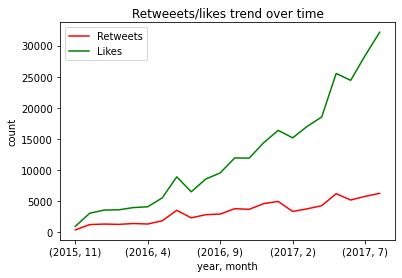

In [79]:
plt.subplots(1, sharex=True)
tweets_master.retweets.groupby([tweets_master['timestamp'].dt.year, tweets_master['timestamp'].dt.month]).mean().plot.line(color='r')
tweets_master.likes.groupby([tweets_master['timestamp'].dt.year, tweets_master['timestamp'].dt.month]).mean().plot.line(color='g')
plt.title('Retweeets/likes trend over time')
plt.ylabel('count')
plt.xlabel('year, month')
plt.legend(('Retweets', 'Likes'));